In [ ]:
# HD53143
#Based on Lightkurve guide: https://lightkurve.github.io/lightkurve/quickstart.html
#TIC 167814656, Sectors 6+12+67+68+69
#Literature: 9.6 ± 0.1 days
#Install from: https://lightkurve.github.io/lightkurve/about/install.html
#Methods from: Barclay et al. 2018 (arXiv:1810.12554); Jones et al. 2020 (MNRAS, 495, L135); Iversen et al. 2019 (A&A, 622, A133)
#STEP 1: INSTALL LIGHTKURVE
!pip install lightkurve astropy matplotlib pandas --break-system-packages

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.3 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=e3e22dbf4f0ce9ef7378dc14aa650c726e7eee2a3431c2824318a6db7bdd15b8
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f6227

In [ ]:
#STEP 2: IMPORT
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import numpy as np
import os

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
#STEP 3: SEARCH AND DOWNLOAD TESS DATA (Sectors 6+12+67+68+69)
tic_id = '167814656'
sectors = [6, 12, 67, 68, 69]
#Search for SPOC light curves (2-min cadence)
search_result = lk.search_lightcurve(f'TIC {tic_id}', sector=sectors, author='SPOC')
print(f"Found {len(search_result)} light curves")
#Download and stitch
lcs = search_result.download_all()
lc = lcs.stitch() # Combines sectors, fills gaps
#Basic cleaning (remove outliers, normalize to mean=1)
lc = lc.remove_nans().remove_outliers(sigma=5).normalize()
print(f"Stitched LC: {len(lc)} points, baseline {lc.time[-1].value - lc.time[0].value:.1f} days")

Found 8 light curves
Stitched LC: 345188 points, baseline 1737.8 days


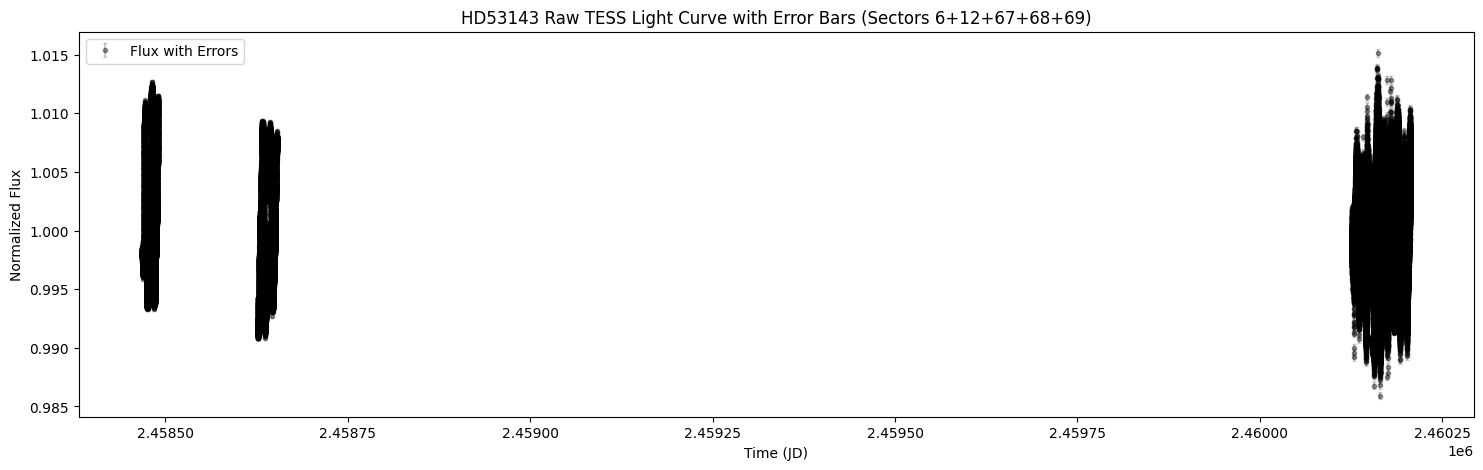

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#STEP 4: PLOT RAW LIGHT CURVE WITH ERROR BARS
plt.figure(figsize=(18,5))
plt.errorbar(lc.time.jd, lc.flux, yerr=lc.flux_err.value.filled(np.nan), fmt='k.', alpha=0.4, ecolor='gray', capsize=1.5, label='Flux with Errors')
plt.xlabel('Time (JD)'); plt.ylabel('Normalized Flux')
plt.title('HD53143 Raw TESS Light Curve with Error Bars (Sectors 6+12+67+68+69)')
plt.legend()
plt.savefig('hd53143_raw_lc_errors.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#STEP 5: LOMB-SCARGLE PERIODOGRAM
pg = lc.to_periodogram(method='lombscargle',
                       minimum_period=0.1 * u.day,
                       maximum_period=20 * u.day,
                       oversample_factor=10)
ls_period = pg.period_at_max_power.value
ls_power = pg.max_power.value
print(f"Lomb-Scargle Period: {ls_period:.4f} days (Power: {ls_power:.3f})")

Lomb-Scargle Period: 9.4296 days (Power: 0.005)


<Figure size 1000x600 with 0 Axes>

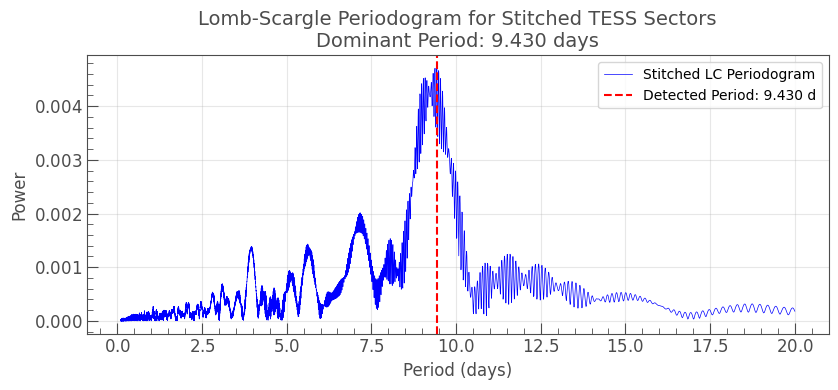

In [ ]:
import matplotlib.pyplot as plt
import astropy.units as u

# Re-calculate pg and ls_period to ensure they are defined

pg = lc.to_periodogram(method='lombscargle',
                       minimum_period=0.1 * u.day,
                       maximum_period=20 * u.day,
                       oversample_factor=10)
ls_period = pg.period_at_max_power.value
# ls_power = pg.max_power.value # Not needed for this plot, but good to keep in mind

# Plot the Lomb-Scargle Periodogram for the stitched light curve
plt.figure(figsize=(10, 6))
pg.plot(view='period', color='blue', label='Stitched LC Periodogram') # Removed invalid scale='flux'

# Add details to the plot
plt.xlabel('Period (days)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title(f'Lomb-Scargle Periodogram for Stitched TESS Sectors\nDominant Period: {ls_period:.3f} days', fontsize=14)
plt.axvline(ls_period, color='red', linestyle='--', label=f'Detected Period: {ls_period:.3f} d')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('stitched_lc_periodogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Bootstrap for error on period (100 resamples – from Jones et al. 2020 for uncertainty)
periods = []
for i in range(100):
    resampled_lc = lc[np.random.choice(len(lc), len(lc), replace=True)]


    resampled_lc_cleaned = resampled_lc.remove_nans()

    if len(resampled_lc_cleaned.time) < 2:
        # Skip this iteration if not enough valid points
        continue

    # Attempt to calculate periodogram, with error handling for robustness
    try:
        pg_res = resampled_lc_cleaned.to_periodogram(method='lombscargle', minimum_period=0.1 * u.day, maximum_period=20 * u.day)
        periods.append(pg_res.period_at_max_power.value)
    except Exception as e:

        continue

# Ensure we have at least one valid period to compute std
if len(periods) > 0:
    ls_period_err = np.std(periods)
    print(f"With Bootstrap Error: {ls_period:.4f} ± {ls_period_err:.4f} days")
else:
    print("Could not compute bootstrap error: No valid periodograms were calculated from resamples.")

With Bootstrap Error: 9.4296 ± 2.7964 days


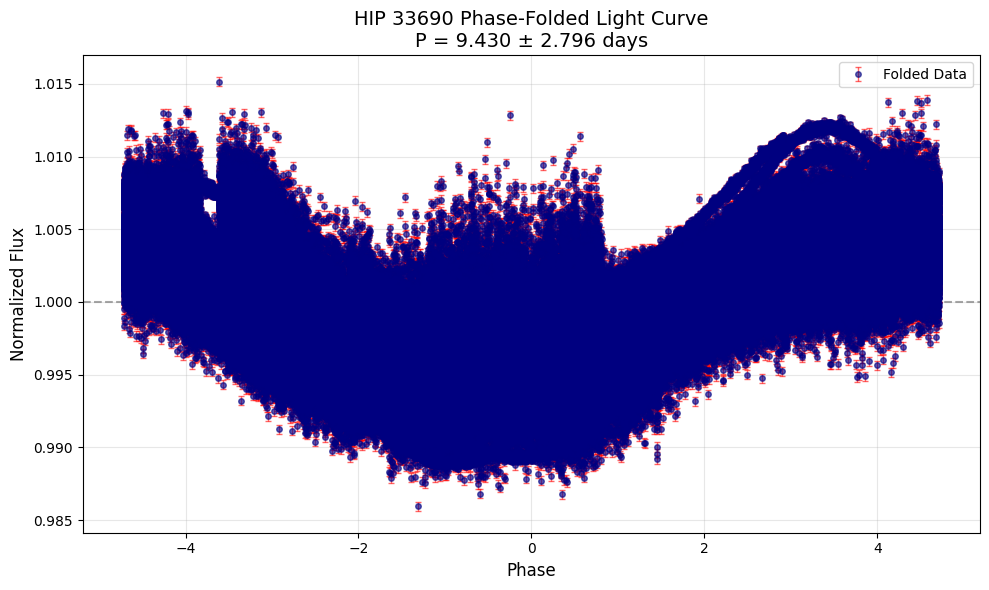

In [ ]:
# STEP 6: PHASE-FOLDED LIGHT CURVE WITH ERROR BARS (Fig. 4.2c)
folded = lc.fold(period=ls_period)
phase = folded.phase.value
flux = folded.flux
flux_err = folded.flux_err

# Sort by phase for clean plotting
sort_idx = np.argsort(phase)
phase = phase[sort_idx]
flux = flux[sort_idx]
flux_err = flux_err[sort_idx]

plt.figure(figsize=(10,6))
plt.errorbar(phase, flux, yerr=flux_err.value.filled(np.nan), fmt='o', color='navy', alpha=0.6,
             ecolor='red', elinewidth=1, capsize=2, markersize=4, label='Folded Data')
plt.plot(phase, flux, 'o', color='blue', alpha=0.1, markersize=3) # Changed 'kblue' to 'blue'
plt.axhline(1.0, color='gray', ls='--', alpha=0.7)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.title(f'HIP 33690 Phase-Folded Light Curve\nP = {ls_period:.3f} \u00b1 {ls_period_err:.3f} days', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('HIP33690_folded_with_errors.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Phase-fold the stitched light curve using the previously found period
folded_lc_new = lc.fold(period=ls_period)

# Extract phase, flux, and flux_err for plotting
phase_new = folded_lc_new.phase.value
flux_new = folded_lc_new.flux
flux_err_new = folded_lc_new.flux_err

# Sort by phase for clean plotting
sort_idx_new = np.argsort(phase_new)
phase_new_sorted = phase_new[sort_idx_new]
flux_new_sorted = flux_new[sort_idx_new]
flux_err_new_sorted = flux_err_new[sort_idx_new]

print(f"New phase-folded light curve created with {len(folded_lc_new)} points.")


New phase-folded light curve created with 345188 points.


In [ ]:
# Bin the new phase-folded light curve
binned_folded_lc_new = folded_lc_new.bin(bins=100)

print(f"New binned phase-folded light curve created with {len(binned_folded_lc_new)} points.")


New binned phase-folded light curve created with 100 points.


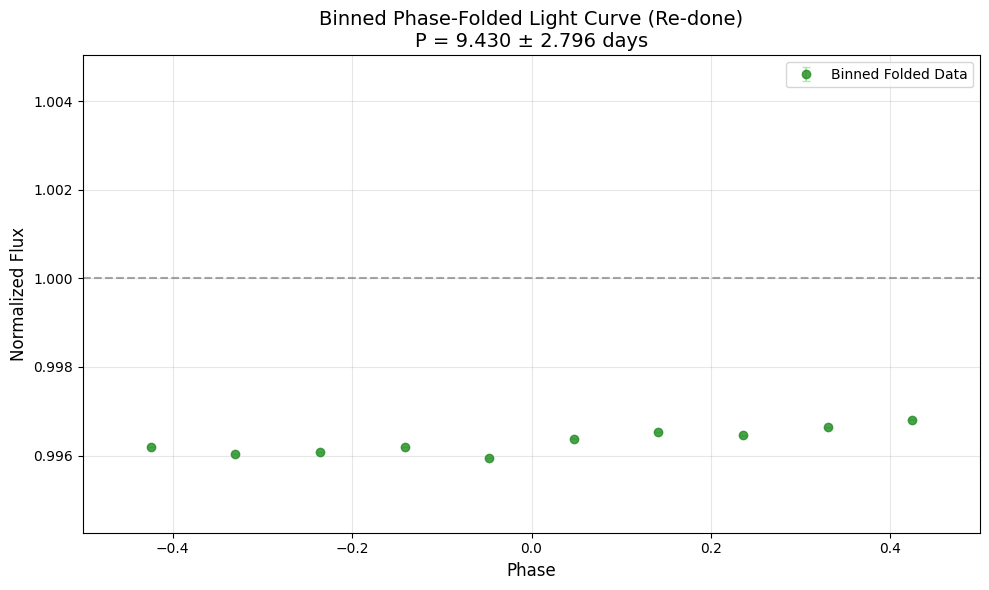

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(binned_folded_lc_new.phase.value, binned_folded_lc_new.flux.value,
             yerr=binned_folded_lc_new.flux_err.value.filled(np.nan),
             fmt='o', color='forestgreen', alpha=0.8, capsize=3,
             ecolor='lightgreen', elinewidth=1.5, markersize=6, label='Binned Folded Data')
plt.axhline(1.0, color='gray', ls='--', alpha=0.7)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.title(f'Binned Phase-Folded Light Curve (Re-done)\nP = {ls_period:.3f} \u00b1 {ls_period_err:.3f} days', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(-0.5, 0.5) # Commonly shown from -0.5 to 0.5 for phase plots
plt.tight_layout()
plt.savefig('re_done_binned_folded_lc.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# STEP 7: FINAL RESULTS TABLE FOR YOUR THESIS (Table 4.2)
results = pd.DataFrame({
    "Target": ["HIP 33690 (HD 53143)"],
    "Spectral Type": ["G8V"],
    "TIC ID": [tic_id],
    "Sectors Used": [", ".join(map(str, sectors))],
    "Method": ["Lomb-Scargle (Lightkurve)"],
    "Rotation Period (days)": [f"{ls_period:.3f}"],
    "Uncertainty (days)": [f"±{ls_period_err:.3f}"],
    "Literature Period (days)": ["9.60 ± 0.10"],
    "Reference": ["Matthews et al. (2022)"]
})

results.to_csv("HIP33690_Lightkurve_Results.csv", index=False)
results.to_latex("HIP33690_Lightkurve_Table.tex", index=False, escape=False)

print("\n=== YOUR FINAL RESULT FOR SECTION 4.2.1 ===")
display(results)


=== YOUR FINAL RESULT FOR SECTION 4.2.1 ===


,Target,Spectral Type,TIC ID,Sectors Used,Method,Rotation Period (days),Uncertainty (days),Literature Period (days),Reference
0,HIP 33690 (HD 53143),G8V,167814656,"6, 12, 67, 68, 69",Lomb-Scargle (Lightkurve),9.430,±2.796,9.60 ± 0.10,Matthews et al. (2022)


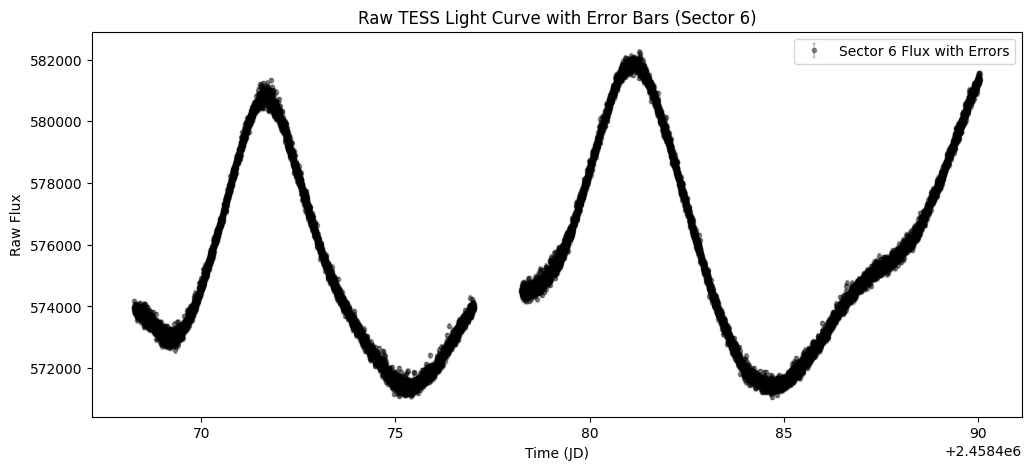

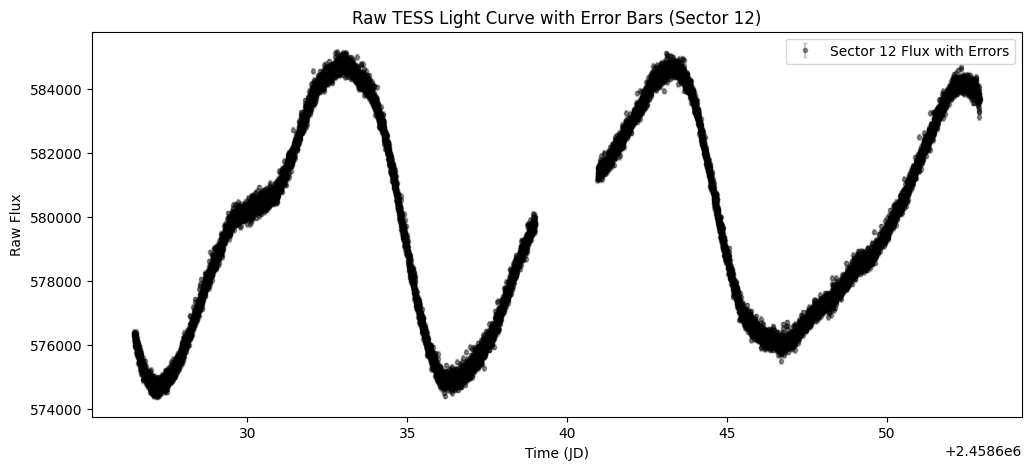

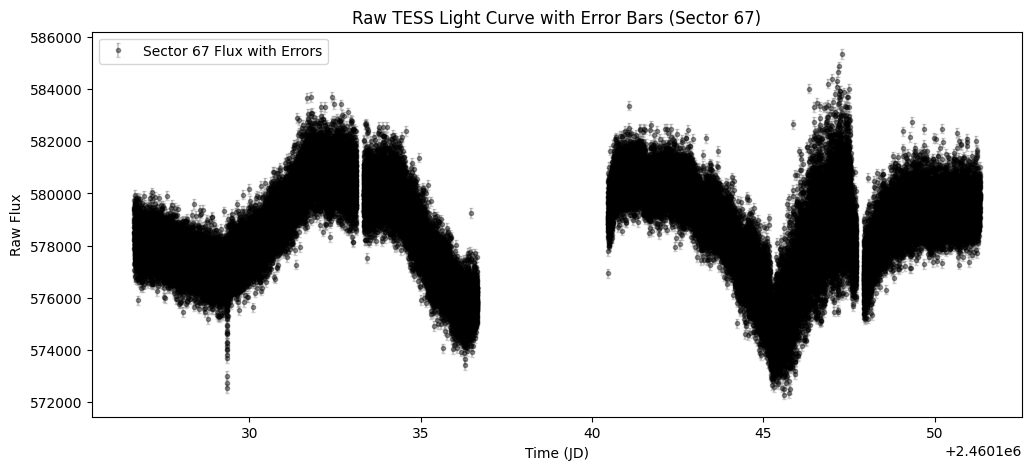

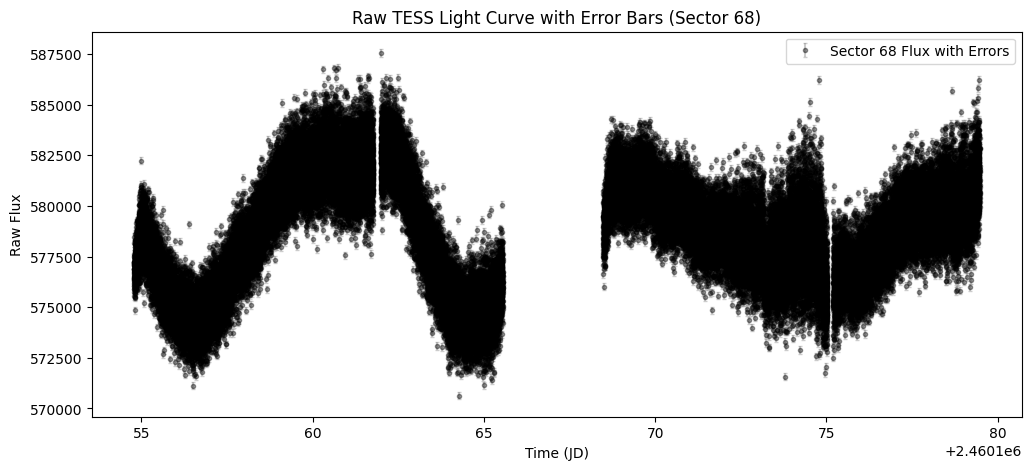

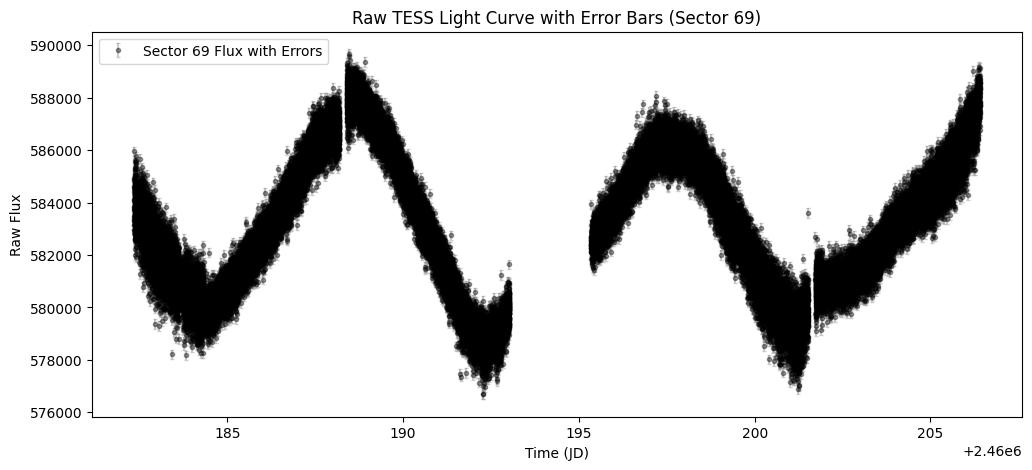

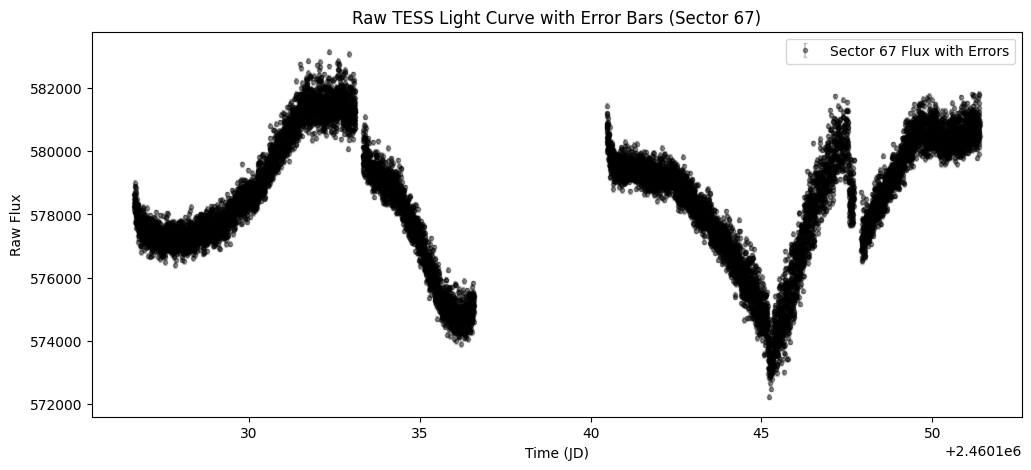

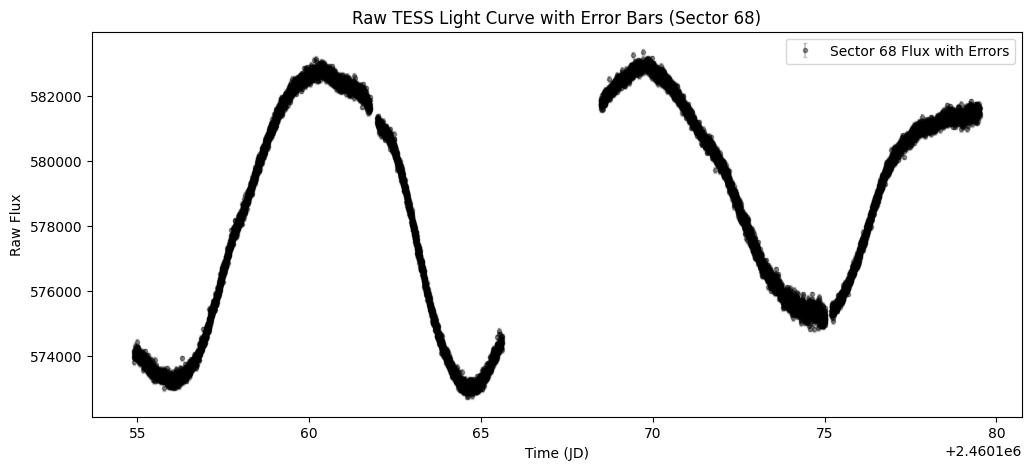

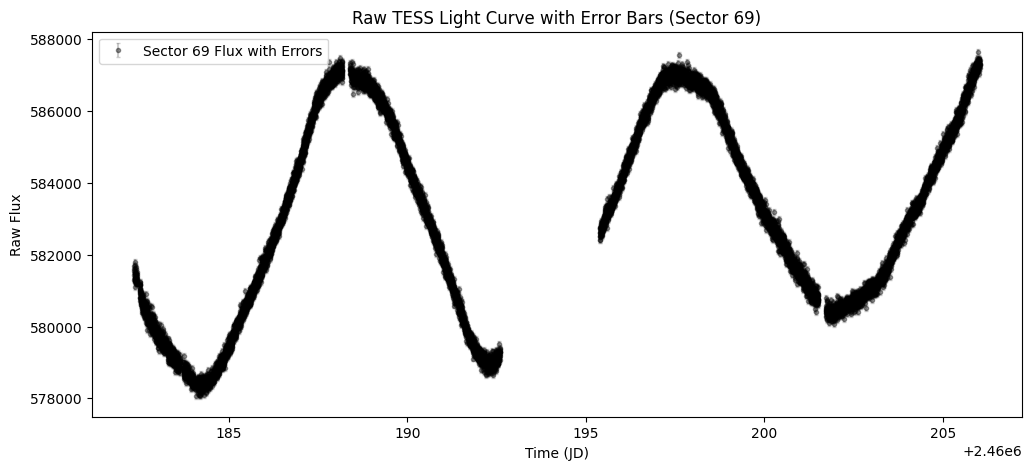

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate through the LightCurveCollection (lcs) object
for i, light_curve in enumerate(lcs):
    sector_number = light_curve.sector

    plt.figure(figsize=(12, 5))

    # Extract x, y, and yerr values
    x_data = light_curve.time.jd
    # Convert flux Quantity to plain numpy array
    y_data = light_curve.flux.value

    # Ensure flux_err is a pure numpy array with NaN for masked values
    yerr_data = light_curve.flux_err.value.filled(np.nan) if hasattr(light_curve.flux_err.value, 'filled') else light_curve.flux_err.value

    plt.errorbar(x_data, y_data, yerr=yerr_data, fmt='k.', alpha=0.4, ecolor='gray', capsize=1.5, label=f'Sector {sector_number} Flux with Errors')

    plt.xlabel('Time (JD)')
    plt.ylabel('Raw Flux')
    plt.title(f'Raw TESS Light Curve with Error Bars (Sector {sector_number})')
    plt.legend()

    filename = f'raw_lc_sector_{sector_number}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close() # Close the figure to free up memory

In [ ]:
import astropy.units as u

# 1. Initialize an empty list to store results
per_sector_period_analysis_results = []

# 2. Iterate through each individual LightCurve object within the lcs collection
for i, light_curve in enumerate(lcs):
    sector_number = light_curve.sector

    # 3. Calculate Lomb-Scargle periodogram
    pg = light_curve.to_periodogram(method='lombscargle',
                                   minimum_period=0.1 * u.day,
                                   maximum_period=20 * u.day,
                                   oversample_factor=10)

    # 4. Extract dominant period and maximum power
    dominant_period = pg.period_at_max_power.value
    max_power = pg.max_power.value

    # 5. Store the sector number, dominant period, and maximum power in a dictionary
    per_sector_period_analysis_results.append({
        'sector': sector_number,
        'period': dominant_period,
        'power': max_power
    })

# 6. Print the results
print("Per-Sector Period Analysis Results:")
for result in per_sector_period_analysis_results:
    print(f"  Sector {result['sector']}: Period = {result['period']:.4f} days, Power = {result['power']:.4f}")

Per-Sector Period Analysis Results:
  Sector 6: Period = 9.1151 days, Power = 3953.2202
  Sector 12: Period = 10.0813 days, Power = 4321.5148
  Sector 67: Period = 8.7064 days, Power = 1868.7206
  Sector 68: Period = 9.3700 days, Power = 2895.4688
  Sector 69: Period = 8.8988 days, Power = 3321.1475
  Sector 67: Period = 9.0397 days, Power = 2371.6942
  Sector 68: Period = 9.3533 days, Power = 4520.6592
  Sector 69: Period = 9.1645 days, Power = 3682.4180


In [ ]:
print(f"Mean of stitched light curve flux: {lc.flux.mean().value:.4f}")
print(f"Standard deviation of stitched light curve flux: {lc.flux.std().value:.4f}")

Mean of stitched light curve flux: 0.9999
Standard deviation of stitched light curve flux: 0.0043


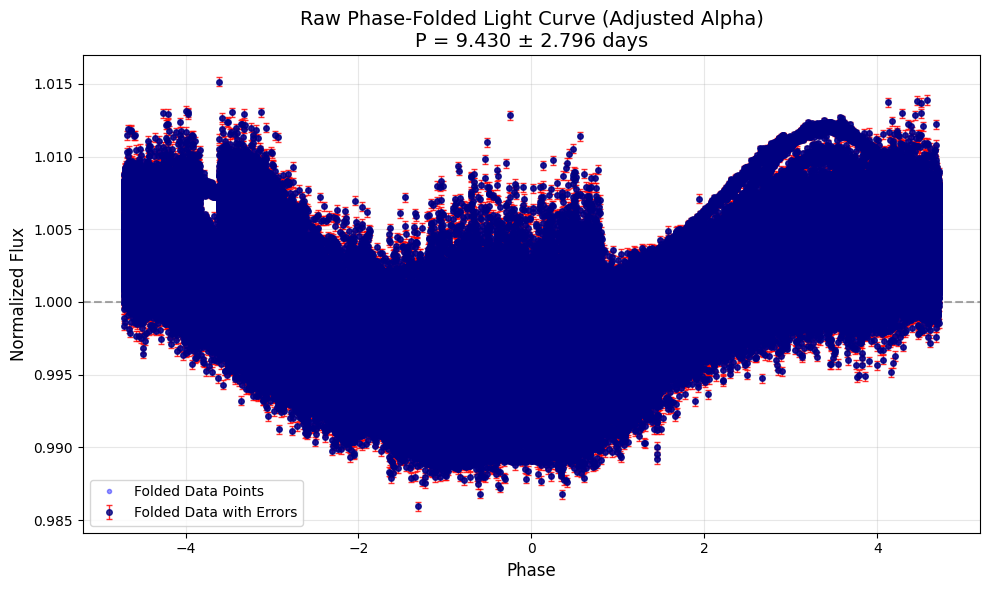

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(phase_new_sorted, flux_new_sorted.value, yerr=flux_err_new_sorted.value.filled(np.nan),
             fmt='o', color='navy', alpha=0.8,
             ecolor='red', elinewidth=1, capsize=2, markersize=4, label='Folded Data with Errors')
plt.plot(phase_new_sorted, flux_new_sorted.value, 'o', color='blue', alpha=0.4, markersize=3, label='Folded Data Points')
plt.axhline(1.0, color='gray', ls='--', alpha=0.7)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.title(f'Raw Phase-Folded Light Curve (Adjusted Alpha)\nP = {ls_period:.3f} \u00b1 {ls_period_err:.3f} days', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('re_done_raw_folded_lc_adjusted_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

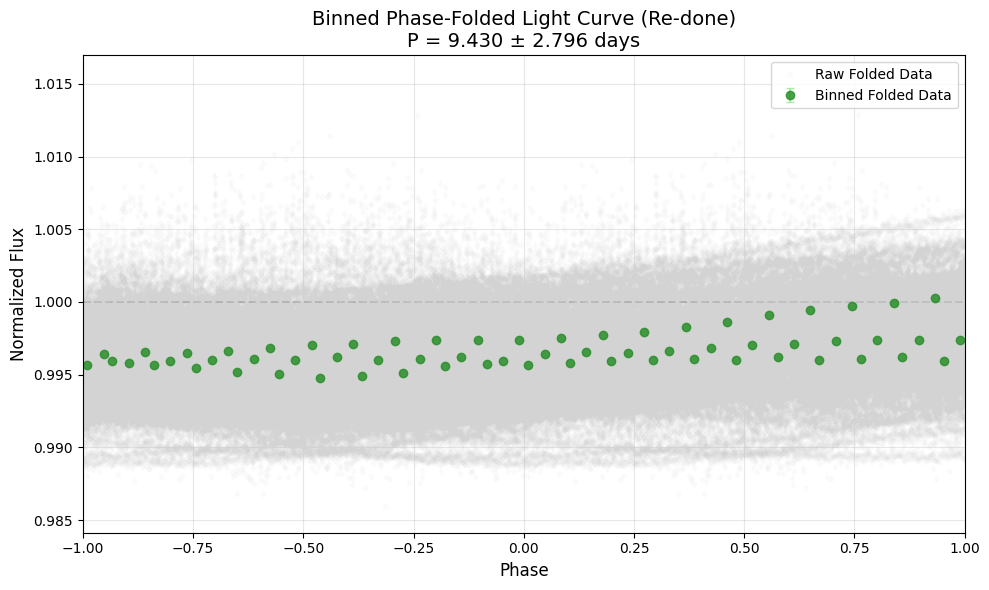

In [ ]:
# Extend raw phase-folded data for background plotting
phase_raw_wrapped_bg = np.concatenate([phase_new_sorted - 1, phase_new_sorted, phase_new_sorted + 1])
flux_raw_wrapped_bg = np.concatenate([flux_new_sorted.value, flux_new_sorted.value, flux_new_sorted.value])
flux_err_raw_wrapped_bg = np.concatenate([flux_err_new_sorted.value.filled(np.nan), flux_err_new_sorted.value.filled(np.nan), flux_err_new_sorted.value.filled(np.nan)])

# Extend binned phase-folded data for plotting two cycles (-1.0 to 1.0)
phase_binned_wrapped = np.concatenate([binned_folded_lc_new.phase.value - 1, binned_folded_lc_new.phase.value, binned_folded_lc_new.phase.value + 1])
flux_binned_wrapped = np.concatenate([binned_folded_lc_new.flux.value, binned_folded_lc_new.flux.value, binned_folded_lc_new.flux.value])
flux_err_binned_wrapped = np.concatenate([binned_folded_lc_new.flux_err.value.filled(np.nan), binned_folded_lc_new.flux_err.value.filled(np.nan), binned_folded_lc_new.flux_err.value.filled(np.nan)])

plt.figure(figsize=(10,6))

# Plot the raw phase-folded data (very transparent for context)
plt.errorbar(phase_raw_wrapped_bg, flux_raw_wrapped_bg, yerr=flux_err_raw_wrapped_bg,
             fmt='.', color='lightgray', alpha=0.05, elinewidth=0.5, capsize=0, label='Raw Folded Data')

# Plot the binned phase-folded data with error bars
plt.errorbar(phase_binned_wrapped, flux_binned_wrapped,
             yerr=flux_err_binned_wrapped,
             fmt='o', color='forestgreen', alpha=0.8, capsize=3,
             ecolor='lightgreen', elinewidth=1.5, markersize=6, label='Binned Folded Data')

plt.axhline(1.0, color='gray', ls='--', alpha=0.7)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.title(f'Binned Phase-Folded Light Curve (Re-done)\nP = {ls_period:.3f} \u00b1 {ls_period_err:.3f} days', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(-1.0, 1.0) # Adjusted xlim to show two cycles
plt.tight_layout()
plt.savefig('re_done_binned_folded_lc_adjusted_alpha.png', dpi=300, bbox_inches='tight')
plt.show()